<a href="https://colab.research.google.com/github/hamednasr/TensorFlow-Projects/blob/main/Tomato_Plant_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Model to Detect Tomato Plant Diseases
### There are nine tomato diseases that we want to detect them from the image of the leaf of the plant.

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Make directory named kaggle and copy kaggle.json file there

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d arjuntejaswi/plant-village

plant-village.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# ! rm -rf /PlantVillage

In [ ]:
! unzip -qq plant-village.zip

In [ ]:
! rm -rf /content/PlantVillage/Pepper__bell___Bacterial_spot
! rm -rf /content/PlantVillage/Pepper__bell___healthy
! rm -rf /content/PlantVillage/Potato___Early_blight
! rm -rf /content/PlantVillage/Potato___Late_blight
! rm -rf /content/PlantVillage/Potato___healthy
! rm -rf /content/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite
! rm -rf /content/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus
! rm -rf /content/PlantVillage/Tomato__Tomato_mosaic_virus
! rm -rf /content/PlantVillage/Tomato_Septoria_leaf_spot

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import mixed_precision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay , accuracy_score, classification_report

In [ ]:
!nvidia-smi

Tue Oct 11 19:32:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
mixed_precision.set_global_policy('mixed_float16')
mixed_precision.global_policy()

<Policy "mixed_float16">

# Create Image Dataset:

In [ ]:
ds = tf.keras.preprocessing.image_dataset_from_directory('/content/PlantVillage',
                                                    labels='inferred',
                                                    label_mode='int',
                                                    batch_size=32,
                                                    image_size=(256, 256),
                                                    shuffle=True)

Found 8983 files belonging to 6 classes.


In [ ]:
classes = ds.class_names
classes

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato__Target_Spot',
 'Tomato_healthy']

In [ ]:
len(ds)

281

In [ ]:
for images, labels in ds.take(1):
  print(images.shape)
  print(labels)

(32, 256, 256, 3)
tf.Tensor([0 5 2 5 2 2 5 5 3 2 5 3 0 4 1 0 1 1 3 4 5 3 3 0 1 5 4 5 2 2 2 4], shape=(32,), dtype=int32)


# Visualizing Images:

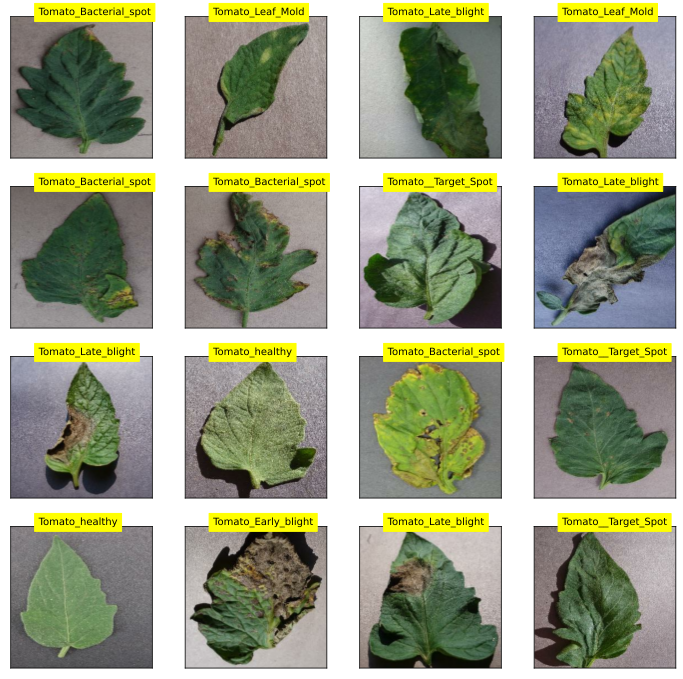

In [ ]:
fig , axs = plt.subplots(4,4,figsize=(12,12))

for  i, ax in enumerate(axs.flatten()):
  ax.imshow(images[i]/255)
  itemname = classes[labels[i]]
  ax.text(50, -3, itemname, fontsize=10 ,backgroundcolor='yellow')
  ax.set_xticks([])
  ax.set_yticks([]);

# Train, Val, Test Split:

In [ ]:
def train_val_test_split(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = train_val_test_split(ds)

In [ ]:
train_ds = train_ds.shuffle(200).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(200).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.shuffle(200).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
len(train_ds),len(val_ds),len(test_ds)

(224, 28, 29)

# Data Augmentation:

In [ ]:
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.Resizing(256,256),
                    tf.keras.layers.RandomFlip(mode="horizontal_and_vertical"),
                    tf.keras.layers.RandomRotation(0.1),
                    tf.keras.layers.RandomZoom(0.1)],
                    name ="data_augmentation"
                    )

# Create Model:

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False , pooling='max')
base_model.trainable = False

inputs = tf.keras.Input(shape=(256,256,3), name='input_layer')

x = data_augmentation(inputs)
x = base_model(x, training = False)

x = tf.keras.layers.Dense(32 , activation ='relu')(x)
x = tf.keras.layers.Dense(6)(x)

outputs = tf.keras.layers.Activation('softmax', dtype = tf.float32)(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf .keras. optimizers.Adam(),
              metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 256, 256, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense (Dense)               (None, 32)                40992     
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                                 
 activation (Activation)     (None, 6)                 0         
                                                             

In [ ]:
for layer in model.layers:
  print(layer.name, layer.dtype , layer.dtype_policy)

input_layer float32 <Policy "float32">
data_augmentation float32 <Policy "float32">
efficientnetb0 float32 <Policy "float32">
dense float32 <Policy "float32">
dense_1 float32 <Policy "float32">
activation float32 <Policy "float32">


# Train Model:

In [ ]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
224/224 [==============================] - 52s 137ms/step - loss: 1.1265 - accuracy: 0.5775 - val_loss: 0.7426 - val_accuracy: 0.7321
Epoch 2/10
224/224 [==============================] - 35s 125ms/step - loss: 0.5329 - accuracy: 0.8153 - val_loss: 0.4949 - val_accuracy: 0.8185
Epoch 3/10
224/224 [==============================] - 35s 125ms/step - loss: 0.3879 - accuracy: 0.8638 - val_loss: 0.3964 - val_accuracy: 0.8527
Epoch 4/10
224/224 [==============================] - 35s 124ms/step - loss: 0.3348 - accuracy: 0.8864 - val_loss: 0.3317 - val_accuracy: 0.8739
Epoch 5/10
224/224 [==============================] - 35s 125ms/step - loss: 0.3161 - accuracy: 0.8883 - val_loss: 0.3031 - val_accuracy: 0.8772
Epoch 6/10
224/224 [==============================] - 35s 125ms/step - loss: 0.2907 - accuracy: 0.8984 - val_loss: 0.2838 - val_accuracy: 0.8984
Epoch 7/10
224/224 [==============================] - 35s 125ms/step - loss: 0.2565 - accuracy: 0.9117 - val_loss: 0.3394 - val_ac

# Save and Load Model:

In [ ]:
model.save('model.h5')

In [ ]:
model = tf.keras.models.load_model('model.h5')

# Evaluate Model:

In [ ]:
model.evaluate(test_ds)

29/29 [==============================] - 10s 80ms/step - loss: 0.2673 - accuracy: 0.9097


[0.26728299260139465, 0.909684419631958]

In [ ]:
pred_prob = np.max(model.predict(test_ds), axis=1)

In [ ]:
pred_labels = np.argmax(model.predict(test_ds), axis=1)
pred_labels[:9]

array([1, 1, 5, 2, 5, 1, 4, 4, 1])

In [ ]:
pred_labels.shape

(919,)

## Visualize Loss, Accuracy Graphs and Prediction:

In [ ]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,1.126521,0.577455,0.742586,0.732143
1,0.532853,0.815290,0.494909,0.818489
2,0.387904,0.863839,0.396416,0.852679
3,0.334837,0.886437,0.331736,0.873884
4,0.316102,0.888253,0.303139,0.877232
5,0.290689,0.898449,0.283778,0.898438
6,0.256547,0.911720,0.339420,0.870536
7,0.241664,0.919262,0.276982,0.895089
8,0.247054,0.914374,0.298113,0.882812
9,0.242398,0.918285,0.227935,0.918527


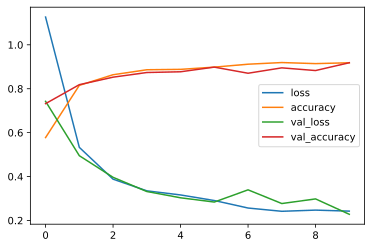

In [ ]:
pd.DataFrame(history.history).plot()

In [ ]:
%pprint

Pretty printing has been turned OFF


In [ ]:
for images, labels in test_ds.take(1):
  print(images.shape)
  print(labels)

(32, 256, 256, 3)
tf.Tensor([1 0 2 1 5 2 5 2 4 4 3 4 0 2 4 2 4 5 0 5 0 0 5 5 4 0 2 2 2 3 0 0], shape=(32,), dtype=int32)


In [ ]:
labels = []
for image, label in test_ds.unbatch():
  labels.append(label.numpy())
labels[:10]

In [ ]:
images = []
for image, label in test_ds.unbatch():
  images.append(image.numpy())

In [ ]:
fig , axs = plt.subplots(4,4,figsize=(12,12))

for  i, ax in enumerate(axs.flatten()):
  ax.imshow(images[i]/255)
  itemname = classes[labels[i]]
  predname = classes[pred_labels[i]]
  prob = pred_prob[i]
  ax.text(50, -3, f'actual:{itemname}\npredicted:{predname}\nprobability:{prob:.3f}', fontsize=8 ,backgroundcolor='yellow')
  ax.set_xticks([])
  ax.set_yticks([]);

## Confusion Matrix:

In [ ]:
cm = confusion_matrix(labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax= ax);

In [ ]:
print(classification_report(labels, pred_labels))